# Immothep
### *Thomas & Orkaëlle*

La société Immothep est une agence immobilière spécialisée dans le vente de biens de particuliers.

Possédant déjà un site internet, elle souhaite pouvoir intégrer à celui-ci, un module d'estimation. Elle possède les ressources nécessaires pour réaliser le code dit "front", ainsi que les ressources graphiques.

Elle ne possède cependant pas les compétences nécessaires pour la réalisation de l'API qui va permettre d'exposer ce nouveau service.

La société nous sollicite donc pour réaliser la partie API en utilisant les données Open Data des Demandes de Valeurs Foncières (DVF) sur l'année 2019.

## 0 - Initialisation

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import immothep_OH as oh

In [4]:
oh.check_folder()
oh.ensure_data_loaded()

Datas already douwnloaded.


## 1 - Récuperation et nettoyage du Dataset

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns

In [6]:
# lecture du fichier raw
raw_df = pd.read_csv('./DATAS/RAW/valeursfoncieres-2019.txt', sep = '|', decimal = ",", encoding="UTF-8")

In [7]:
#création dataframe pandas avec les colonnes souhaitées
df = raw_df[["Nature mutation","Valeur fonciere","Nombre de lots","Code postal","Code departement","Code type local","Type local","Surface reelle bati","Surface Carrez du 1er lot","Nombre pieces principales","Surface terrain"]]

In [8]:
# Suppression ou mises à zéro des lignes vides
df.dropna(subset = ["Valeur fonciere"], inplace = True)
df.dropna(subset = ["Code postal"], inplace = True)
df.dropna(subset = ["Surface reelle bati"], inplace = True)
df.dropna(subset = ["Code departement"], inplace = True)
df['Surface terrain'] = df['Surface terrain'].fillna(0)
df.isnull().sum()

Nature mutation                    0
Valeur fonciere                    0
Nombre de lots                     0
Code postal                        0
Code departement                   0
Code type local                    0
Type local                         0
Surface reelle bati                0
Surface Carrez du 1er lot    1133764
Nombre pieces principales          0
Surface terrain                    0
dtype: int64

In [9]:
# Suppression du département Corse pour éviter les str
df = df.drop(df.loc[(df["Code departement"] == "2A") | (df["Code departement"] == "2B")].index)

In [10]:
# Conversion en int
df["Code postal"] = df["Code postal"].astype('int8')
df["Code type local"] = df["Code type local"].astype('int8')
df["Code departement"] = df["Code departement"].astype('int8')

In [11]:
# Filrage sur les natures 'Ventes', et sur les 'Maisons' et 'Appartements'
df = df.loc[(df['Nature mutation'] == 'Vente') & ((df['Type local'] == 'Maison') | (df['Type local'] == 'Appartement'))]

In [12]:
# Suppression des ventes de lots multiples
df = df.drop(df.loc[df["Nombre de lots"]> 1].index)
df.groupby("Nombre de lots")[['Valeur fonciere']].count().sort_values("Nombre de lots")

,Valeur fonciere
Nombre de lots,
0,600887
1,181598


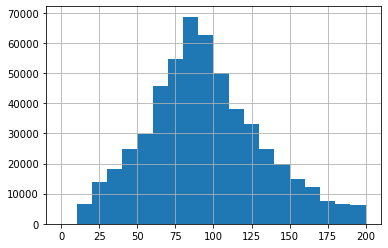

In [13]:
# Nettoyage des surfaces (suppression incohérence, choix de la plus appropriée, suppression des NA)
df = df.drop(df.loc[df["Surface Carrez du 1er lot"] > df["Surface reelle bati"]].index)
df['Surface'] = np.where(df["Code type local"] == 1, df["Surface reelle bati"],df["Surface Carrez du 1er lot"])
df.dropna(subset = ["Surface"], inplace = True)
df = df.drop(df.loc[df["Surface"]> 200].index)
df = df.drop(df.loc[df["Surface"]< 10].index)
df['Surface'].hist(bins=20, range=(0,200))

In [15]:
# Supprimer les biens dont le nbre de pièces > 7
df = df.drop(df.loc[(df["Nombre pieces principales"]> 7) & (df["Nombre pieces principales"] < 1)].index)

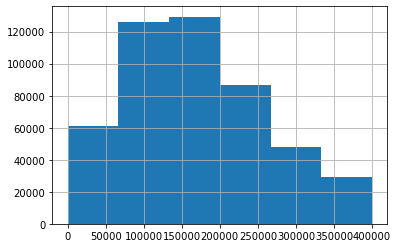

In [16]:
# Nettoyage des valeurs foncières extrèmes
df = df.drop(df.loc[df["Valeur fonciere"]> 600000].index)
df['Valeur fonciere'].hist(bins=6, range=(0,400000))

## 2 - Matrice de correlation

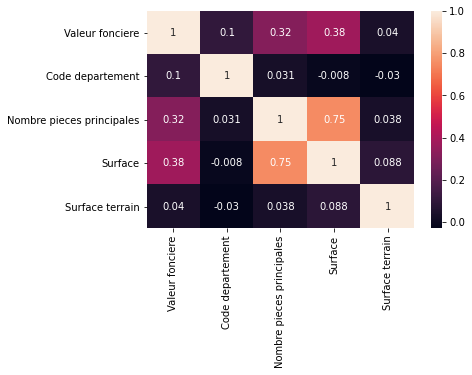

In [17]:
# Création de la matrice de correlation
df_matrice = df[["Valeur fonciere","Code departement","Nombre pieces principales","Surface","Surface terrain"]]
matrice_corr = df_matrice.corr().round(3)
sns.heatmap(data=matrice_corr, annot=True)

## 3 - Entrainement

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [53]:
df_train = df.sample(n=50, random_state=5)

In [54]:
X = pd.DataFrame(np.c_[df_train["Surface"],df_train["Nombre pieces principales"],df_train['Code departement'],df_train['Surface terrain']], columns= ["Surface","Nombre pieces principales","Code departement","Surface terrain"])
Y = df_train["Valeur fonciere"]

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(40, 4)
(10, 4)
(40,)
(10,)


In [56]:
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)

LinearRegression()

In [57]:
y_train_predict = lmodellineaire.predict(X_train)
rmse = round(np.sqrt(mean_squared_error(Y_train, y_train_predict)),2)
r2 = round(r2_score(Y_train, y_train_predict),4)
 
print("La performance du modèle sur la base dapprentissage")
print('--------------------------------------')
print(f"L'erreur quadratique moyenne est {rmse}€")
print(f"le score R2 est {r2}")
print('\n')

La performance du modèle sur la base dapprentissage
--------------------------------------
L'erreur quadratique moyenne est 123133.04€
le score R2 est 0.1483


